# Description
**This assignment focuses on learning and using simple bias mitigation methods. Therefore, we provide a baseline for data processing and model training. You can conduct this bias mitigation experiment based on this reference baseline. 
<font color=red>(note: based on this baseline, but not limited to this baseline, we encourage trying more methods)</font>**

# Loading packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

#Visualisation Library
import seaborn as sns
import matplotlib.pyplot as plt

#To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

#Classification model 
from sklearn.linear_model import LogisticRegression

#Classification model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#To split the model into training and testing data
from sklearn.model_selection import train_test_split

#Different model improvement packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Evaluation metrics
from sklearn import metrics

# Loading the dataset

In [2]:
train=pd.read_csv("./train.csv")
test=pd.read_csv('./test.csv')

#Creating a copy for backup
train_og=train.copy()
test_og=test.copy()

In [3]:
#Checking the data types of our data
train.dtypes

Loan_ID               object
Gender                object
Race                  object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

* All the object data types needs to be converted into int so we can build a model 
* Dependents has to be int which has to be looked into

In [4]:
#Checking the number of rows and columns in our dataset
train.shape,test.shape

((614, 14), (367, 13))

In [5]:
#Checking the bal of target variable
train["Loan_Status"].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

* There isnt a good bal between our target which needs to be managed using ROS method or stratify

# Visualising Categorical variables

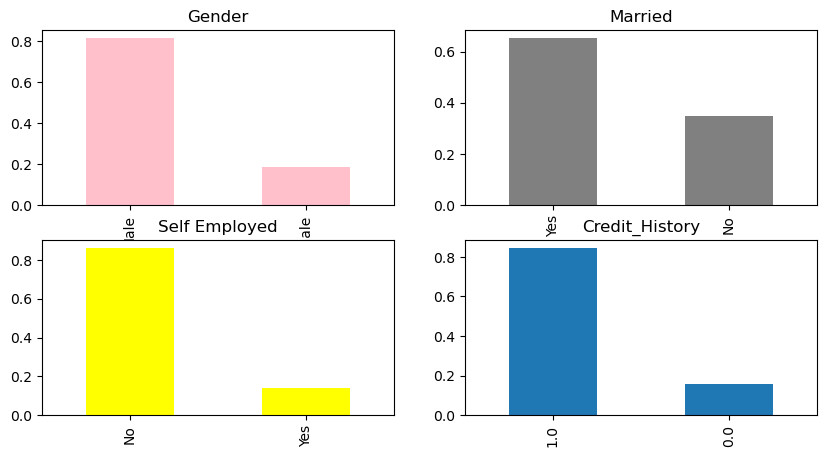

In [6]:
plt.figure(1) 
plt.subplot(2,2,1)
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Gender',color='pink')
plt.subplot(2,2,2)
train['Married'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Married',color='grey')
plt.subplot(2,2,3)
train['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Self Employed',color='yellow')
plt.subplot(2,2,4)
train['Credit_History'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Credit_History')
plt.show()

Most loan Applicants are male, married and not self_employed with a 1.0 credit history

# Visualising Ordinal Variable

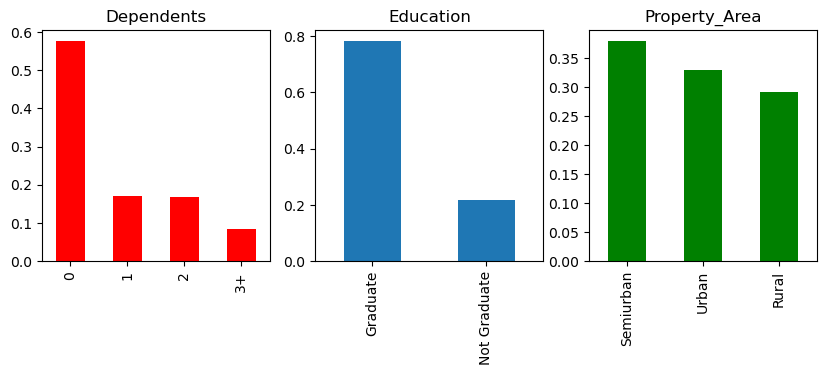

In [7]:
plt.figure(1)
plt.subplot(1,3,1)
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Dependents',color='red')
plt.subplot(1,3,2)
train['Education'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Education')
plt.subplot(1,3,3)
train['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Property_Area',color='green')
plt.show()

Most applicants dont have dependents are graduates and belong from semiurban area

In [8]:
train['Dependents']=train['Dependents'].replace('3+','3')

# Visualising Numeric Variables and checking for outliers

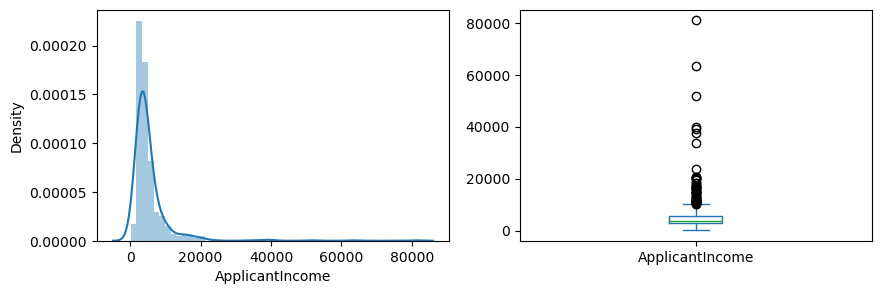

In [9]:
plt.figure(1)
plt.subplot(1,2,1)
sns.distplot(train['ApplicantIncome'])
plt.subplot(1,2,2)
train['ApplicantIncome'].plot.box(figsize=(10,3))
plt.show()

We can observe that there is high left skewness in the applicant income which means there are outliers which needs to be treated before we build our model

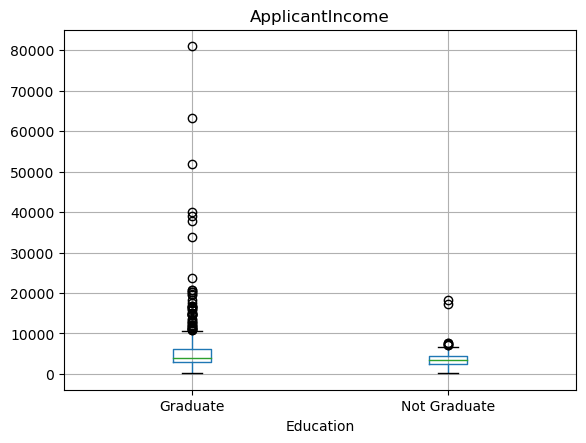

In [10]:
#Visualizing the application income considering whether applicant is graduate or not
train.boxplot(column='ApplicantIncome',by='Education')
plt.suptitle("")
plt.show()

We can observe that most anomalies are in case of Graduates compared to non graduates

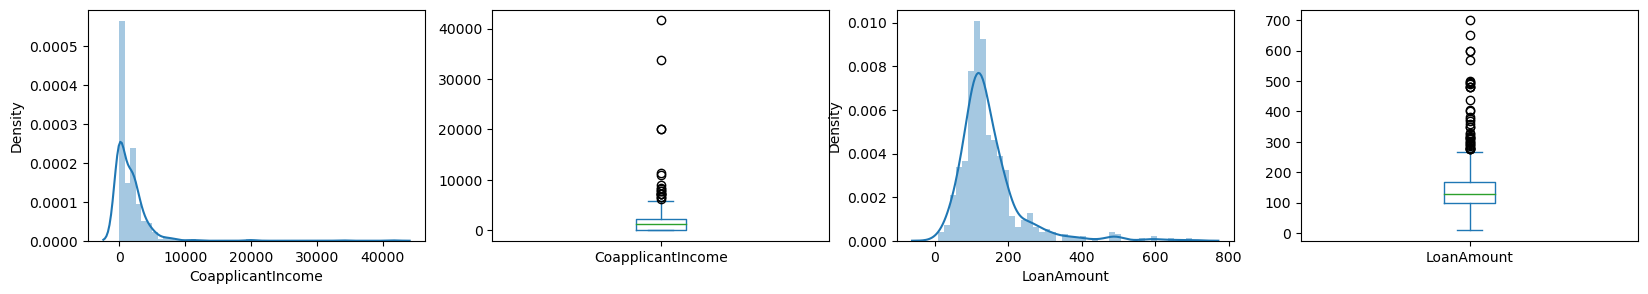

In [11]:
plt.figure(1)
plt.subplot(1,4,1)
sns.distplot(train['CoapplicantIncome'])
plt.subplot(1,4,2)
train['CoapplicantIncome'].plot.box(figsize=(20,3))
plt.subplot(1,4,3)
sns.distplot(train['LoanAmount'])
plt.subplot(1,4,4)
train['LoanAmount'].plot.box()
plt.show()

Theres high skewnesss for coapplicant income and light skewness in case of loan amount

# Bivariate Analysis

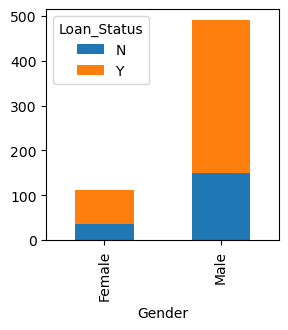

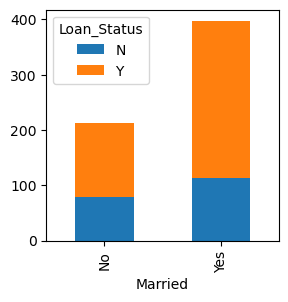

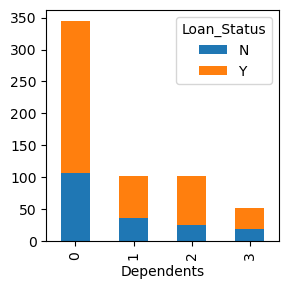

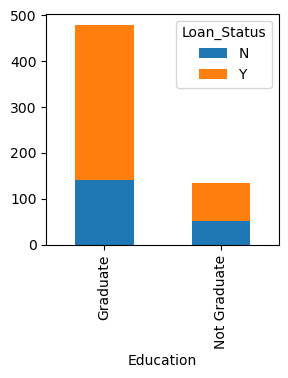

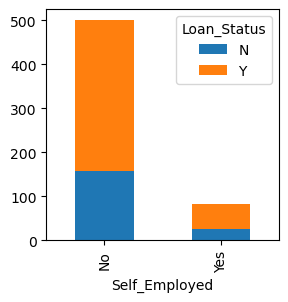

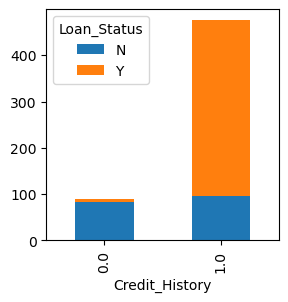

In [12]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.plot(kind='bar',stacked=True,figsize=(3,3))

married=pd.crosstab(train['Married'],train['Loan_Status'])
married.plot(kind='bar',stacked=True,figsize=(3,3))

dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.plot(kind='bar',stacked=True,figsize=(3,3))

education=pd.crosstab(train['Education'],train['Loan_Status'])
education.plot(kind='bar',stacked=True,figsize=(3,3))

selfemployed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
selfemployed.plot(kind='bar',stacked=True,figsize=(3,3))

credithistory=pd.crosstab(train['Credit_History'],train['Loan_Status'])
credithistory.plot(kind='bar',stacked=True,figsize=(3,3))

plt.show()

* From the above visualisation its clear that mostly graduates, self-employed and applicants with 0 dependents have high chances of loan approval
* Applicants whose credit history is 0 have very low chances of getting loan

# Correlation of dataset

In [13]:
print(train)

      Loan_ID  Gender   Race Married Dependents     Education Self_Employed  \
0    LP001002    Male  Black      No          0      Graduate            No   
1    LP001003    Male  Black     Yes          1      Graduate            No   
2    LP001005    Male  Black     Yes          0      Graduate           Yes   
3    LP001006    Male  Black     Yes          0  Not Graduate            No   
4    LP001008    Male  Black      No          0      Graduate            No   
..        ...     ...    ...     ...        ...           ...           ...   
609  LP002978  Female  Black      No          0      Graduate            No   
610  LP002979    Male  Black     Yes          3      Graduate            No   
611  LP002983    Male  White     Yes          1      Graduate            No   
612  LP002984    Male  White     Yes          2      Graduate            No   
613  LP002990  Female  Black      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount

In [14]:
# 转换为数字，保存在train_no_loan_id
def preprocess_data(df):
    # Male为1，Female为0
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
    
    # White为1，Black为0
    df['Race'] = df['Race'].map({'White': 1, 'Black': 0})
    
    # Married Yes为1，NO为0
    df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
    
    # Graduate为1， Not Graduate为0
    df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
    
    # Self_Employed Yes为1，NO为0
    df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
    
    # Urban为1，Rural为3，Semiurban为2
    df['Property_Area'] = df['Property_Area'].map({'Urban': 1, 'Rural': 3, 'Semiurban': 2})
    
    # Loan_Status Y为1，N为0
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
    
    return df

train_no_loan_id = train.drop(columns=['Loan_ID'])
train_no_loan_id = preprocess_data(train_no_loan_id)# 转换训练集
# test = preprocess_data(test)


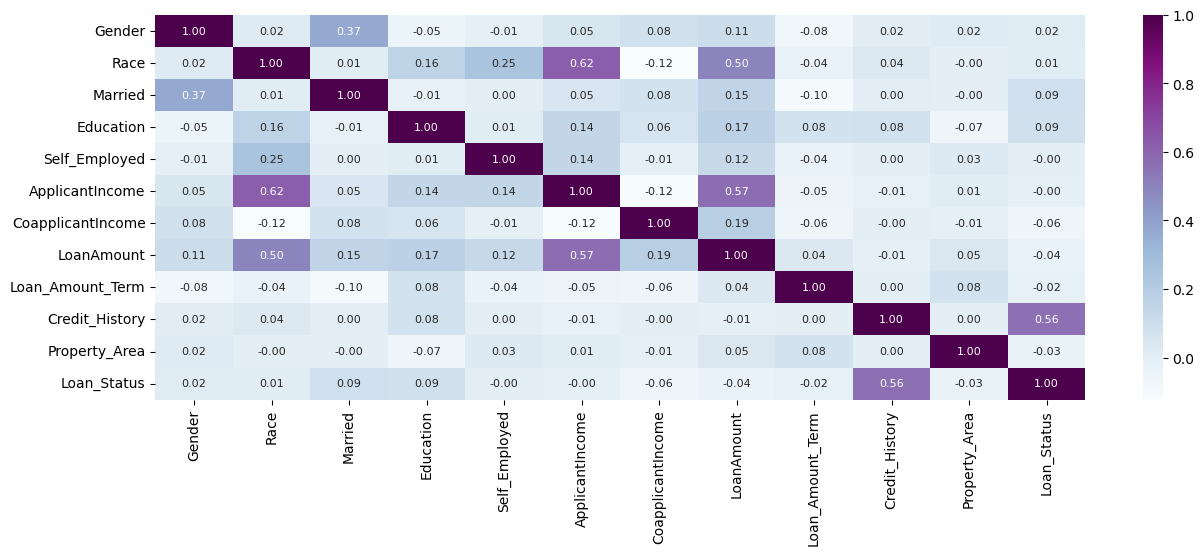

In [15]:
plt.figure(figsize=(15,5))
sns.heatmap(train_no_loan_id.corr(),cmap='BuPu',annot=True,fmt=".2f",annot_kws={"size": 8})
plt.show()

# Missing Value Imputation

In [16]:
#Creating variables that stores all numeric and object columns
numeric_col= train.select_dtypes([int,float]).columns
object_col= train.select_dtypes([object]).columns
print('object columns: ', object_col)
print('numeric columns:' , numeric_col)

object columns:  Index(['Loan_ID', 'Gender', 'Race', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')
numeric columns: Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


In [17]:
#Inputing the missing numeric data with mean value
for i in train[numeric_col]:
    print(i,':' ,round(train[i].mean(),2))
    train[i].fillna(round(train[i].mean(),2),inplace=True)

ApplicantIncome : 5403.46
CoapplicantIncome : 1621.25
LoanAmount : 146.41
Loan_Amount_Term : 342.0
Credit_History : 0.84


In [18]:
train.isnull().sum()

Loan_ID               0
Gender               13
Race                  0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

All the numeric missing values have been imputed 

In [19]:
#Imputing object data with mode
for i in train[object_col]:
    print(i,':', train[i].mode()[0])
    train[i].fillna(train[i].mode()[0],inplace=True)

Loan_ID : LP001002
Gender : Male
Race : Black
Married : Yes
Dependents : 0
Education : Graduate
Self_Employed : No
Property_Area : Semiurban
Loan_Status : Y


In [20]:
train.isnull().sum()

Loan_ID              0
Gender               0
Race                 0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

NO more missing values 

# Understanding the uniqueness of our data

In [21]:
#Checking the uniquness of our data
train.nunique()

Loan_ID              614
Gender                 2
Race                   2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
Loan_Status            2
dtype: int64

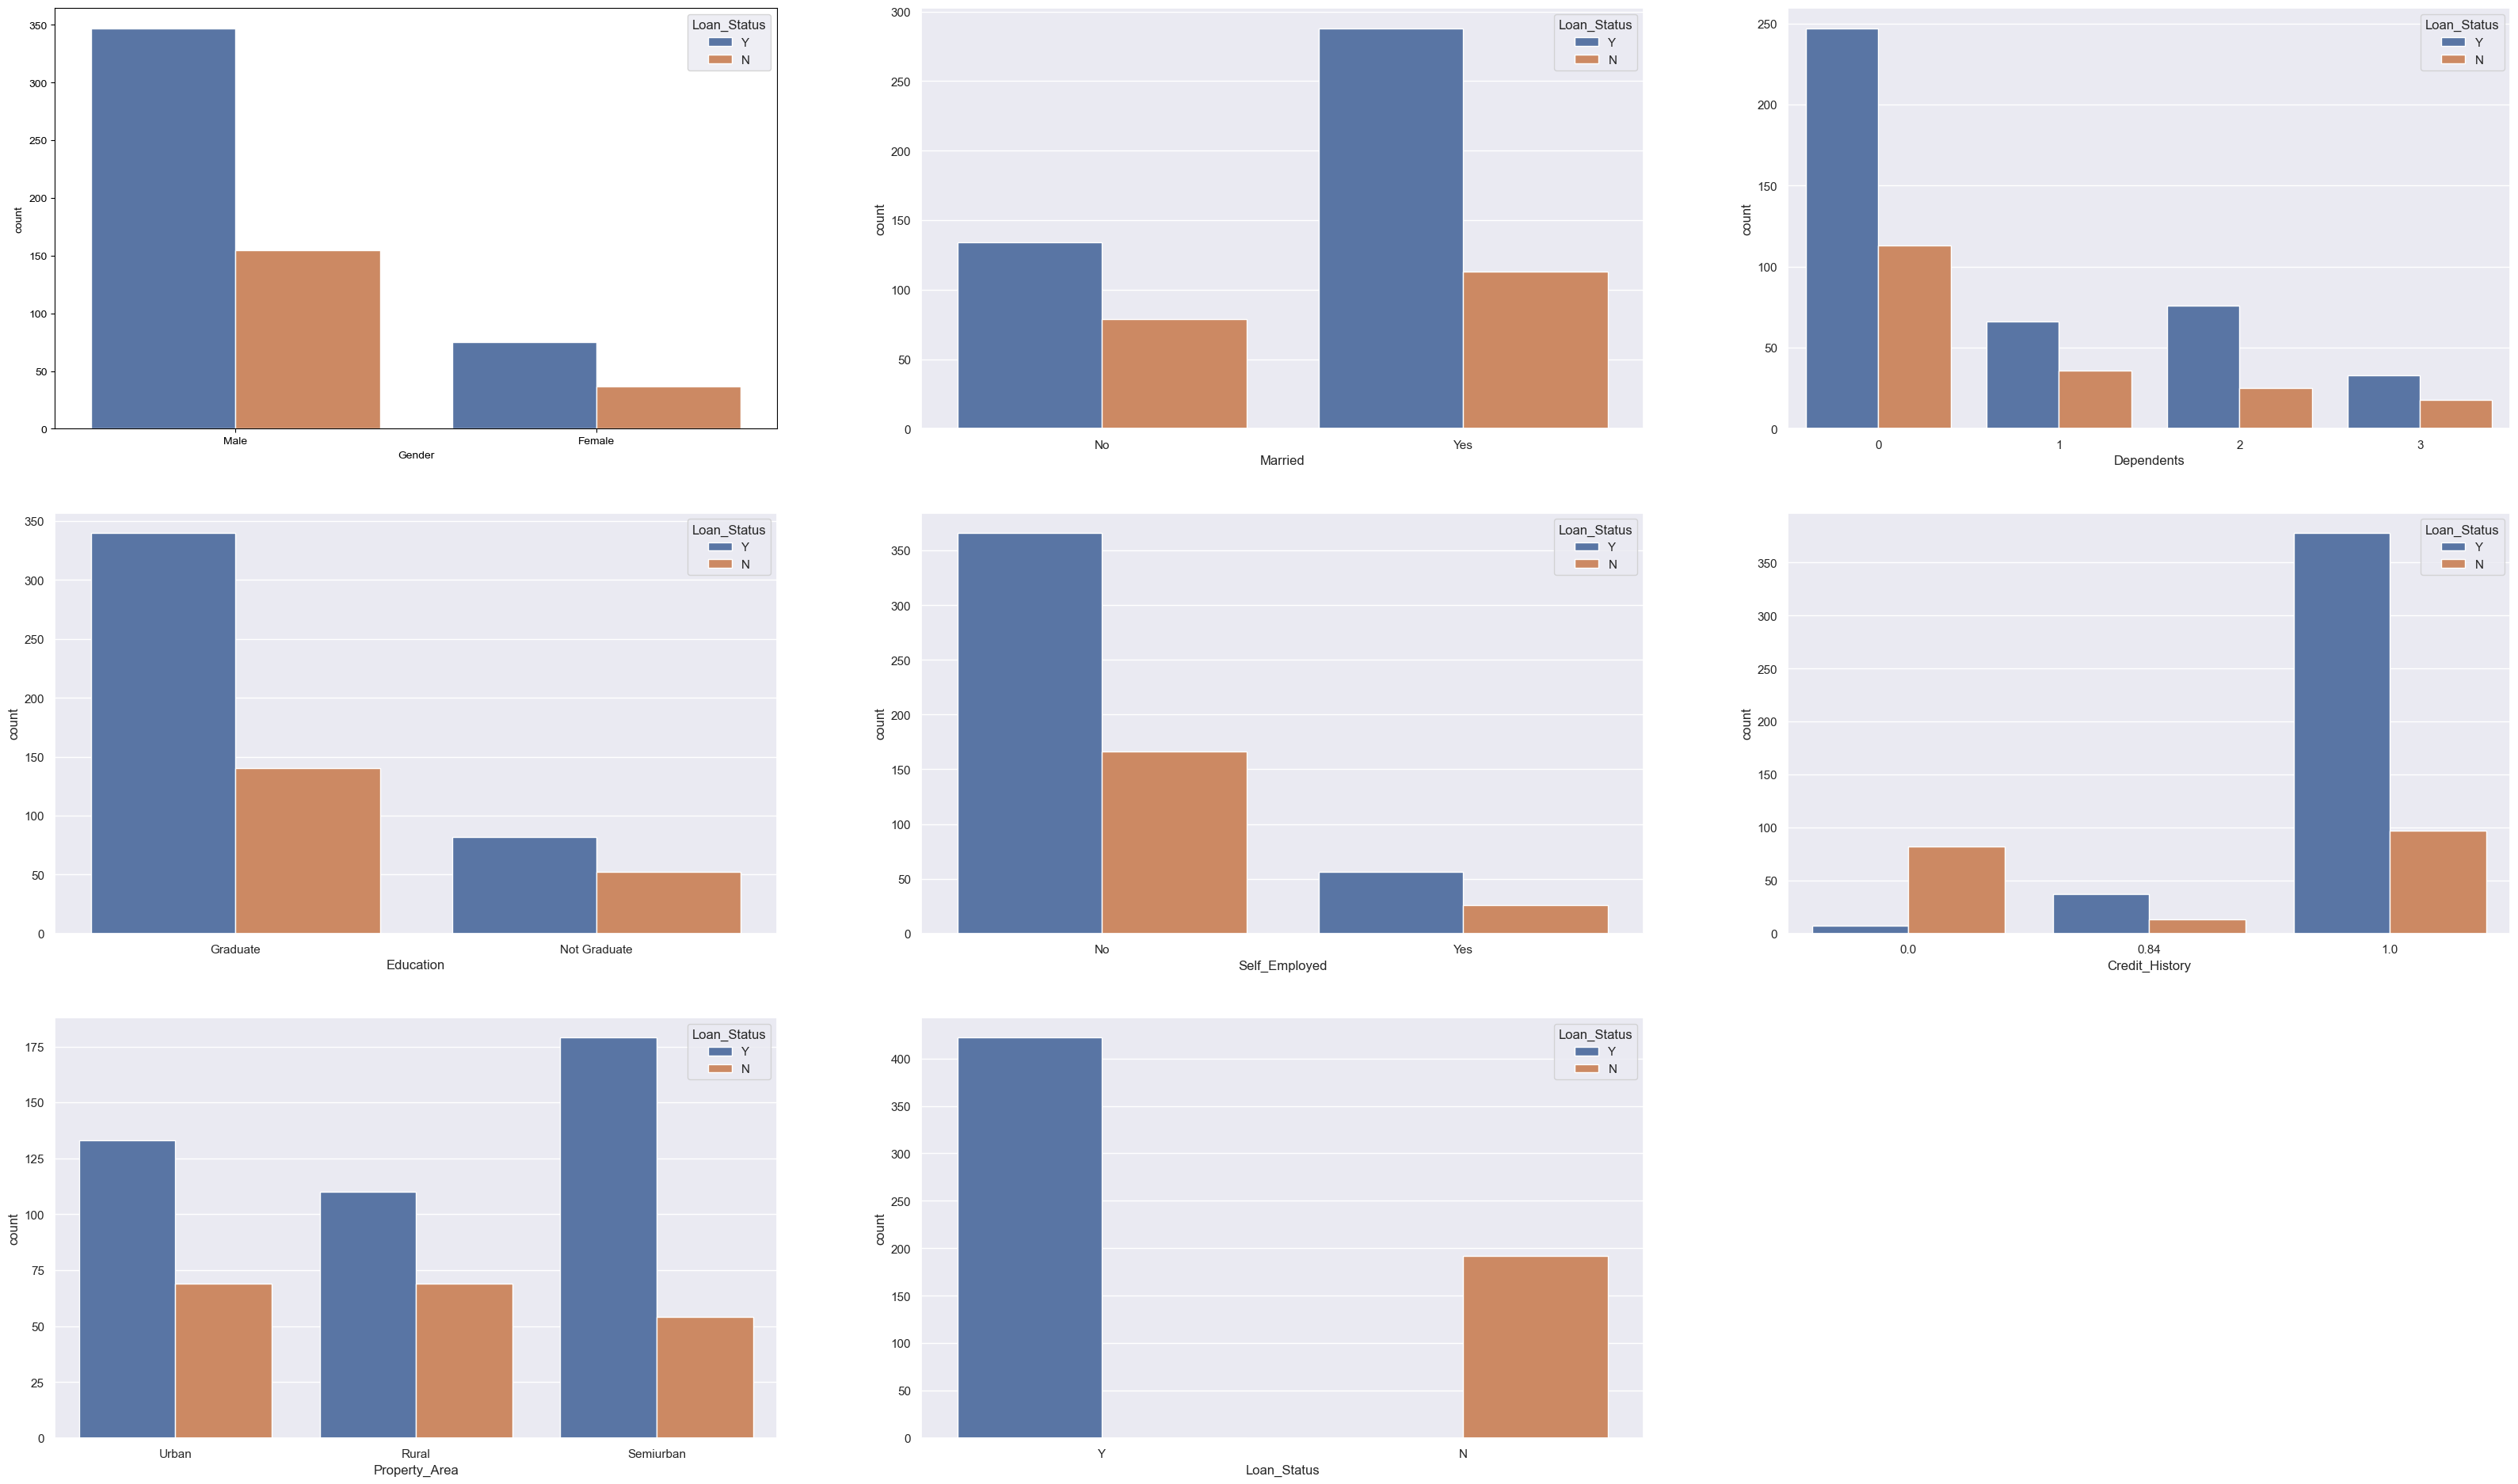

In [22]:
#Visualising features with low unique values for better understanding
v= train[['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area' \
          ,'Loan_Status']].columns
plt.figure(figsize=(40,40))
for i,col in enumerate(v):
    plt.subplot(5,3,i+1)
    sns.set(style='darkgrid')
    sns.countplot(x=train[col],hue=train['Loan_Status'])
plt.show()

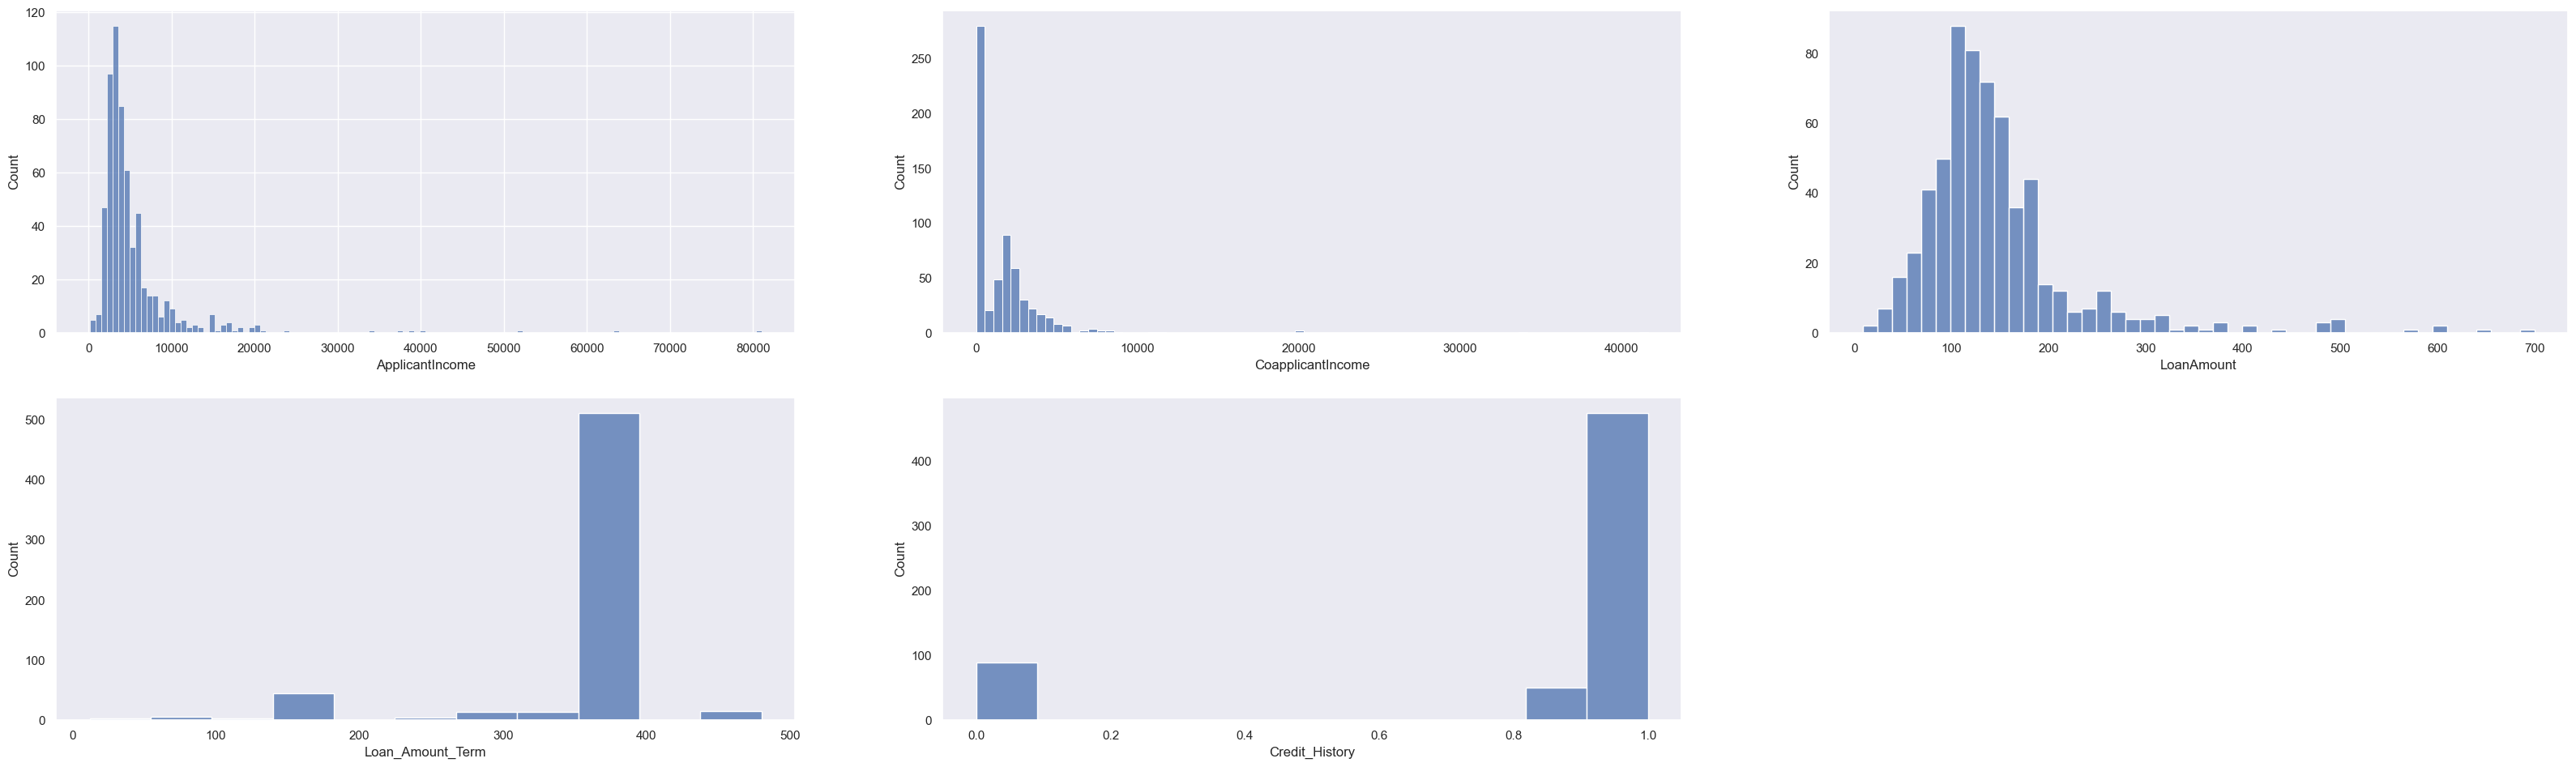

In [23]:
plt.figure(figsize=(40,30))
for i,col in enumerate(numeric_col):
    plt.subplot(5,3,i+1)
    sns.set_style('dark')
    sns.histplot(data=train[col])
plt.show()

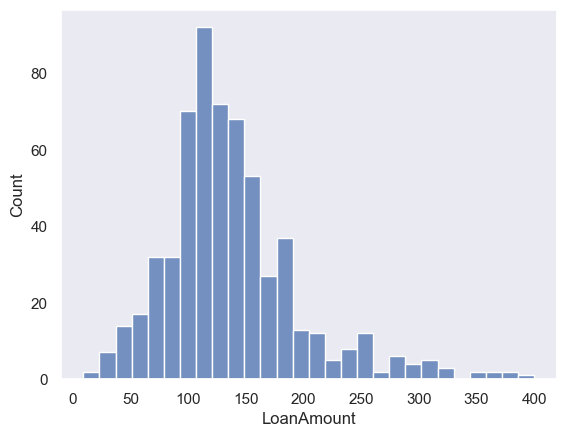

In [24]:
train.drop(train['LoanAmount'][train['LoanAmount']>400].index, inplace=True)
sns.histplot(train['LoanAmount'])
plt.show()

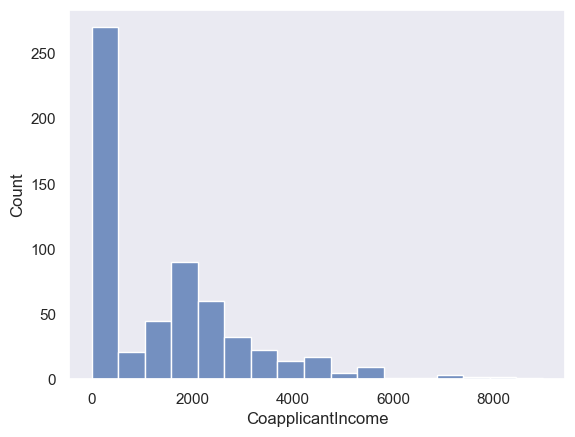

In [25]:
train.drop(train['CoapplicantIncome'][train['CoapplicantIncome']>10000].index, inplace=True)
sns.histplot(train['CoapplicantIncome'])
plt.show()

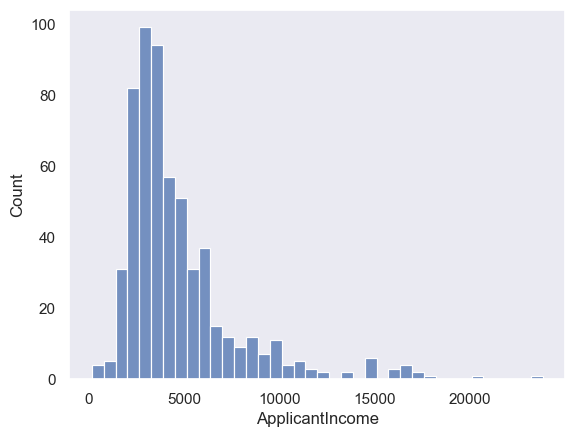

In [26]:
train.drop(train['ApplicantIncome'][train['ApplicantIncome']>25000].index, inplace=True)
sns.histplot(train['ApplicantIncome'])
plt.show()

# Treating object data types for model building

In [27]:
#Chekcing the remaining columns to treat the object data types
train.columns

Index(['Loan_ID', 'Gender', 'Race', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            591 non-null    object 
 1   Gender             591 non-null    object 
 2   Race               591 non-null    object 
 3   Married            591 non-null    object 
 4   Dependents         591 non-null    object 
 5   Education          591 non-null    object 
 6   Self_Employed      591 non-null    object 
 7   ApplicantIncome    591 non-null    int64  
 8   CoapplicantIncome  591 non-null    float64
 9   LoanAmount         591 non-null    float64
 10  Loan_Amount_Term   591 non-null    float64
 11  Credit_History     591 non-null    float64
 12  Property_Area      591 non-null    object 
 13  Loan_Status        591 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 69.3+ KB


In [29]:
#Converting dependents into int as it includes integer values
train['Dependents']=train['Dependents'].astype('int')

In [30]:
#Mapping the object columns to convert it into binary from and then change the data type to int
train['Married']=train['Married'].map({'Yes':1, 'No':0})
train['Education']=train['Education'].map({'Graduate':1, 'Not Graduate':0})
train['Self_Employed']=train['Self_Employed'].map({'Yes':1, 'No':0})
train['Loan_Status']=train['Loan_Status'].map({'Y':1, 'N':0})

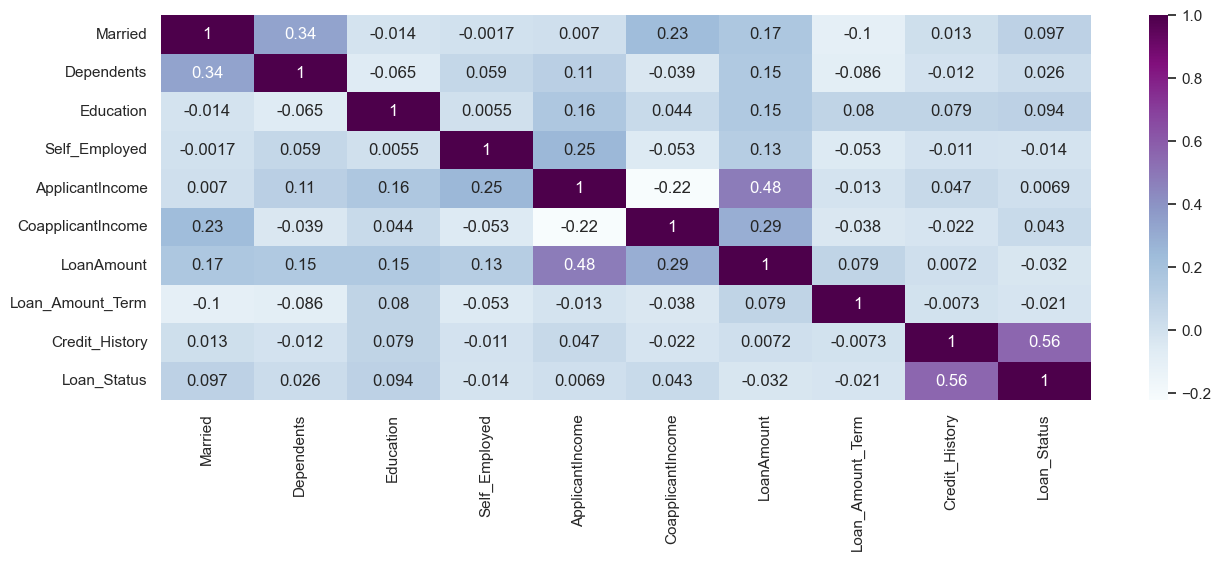

In [31]:
#Checking for correlation
plt.figure(figsize=(15,5))
sns.heatmap(train.corr(),cmap='BuPu',annot=True)
plt.show()

* Loan status is highly correlated to Credit history
* we can see some multicoreniality - for eg- applicant income is highly correlated to loan amount

# Dropping redundant columns

In [32]:
train.drop('Loan_ID',axis=1, inplace=True)
train_expaned = train

In [33]:
#Using get dummies for the remaining object columns for which mapping or encoder cant be used 
train=pd.get_dummies(train)
train.head()

Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0        0           0          1              0             5849   
1        1           1          1              0             4583   
2        1           0          1              1             3000   
3        1           0          0              0             2583   
4        0           0          1              0             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0      146.41             360.0             1.0   
1             1508.0      128.00             360.0             1.0   
2                0.0       66.00             360.0             1.0   
3             2358.0      120.00             360.0             1.0   
4                0.0      141.00             360.0             1.0   

   Loan_Status  Gender_Female  Gender_Male  Race_Black  Race_White  \
0            1              0            1           1           0   
1            0              0            1           1           0   
2            1              0            1           1           0   
3            1              0            1           1           0   
4            1              0            1           1           0   

   Property_Area_Rural  Property_Area_Semiurban  Property_Area_Urban  
0                    0                        0                    1  
1                    1                        0                    0  
2                    0                        0                    1  
3                    0                        0                    1  
4                    0                        0                    1

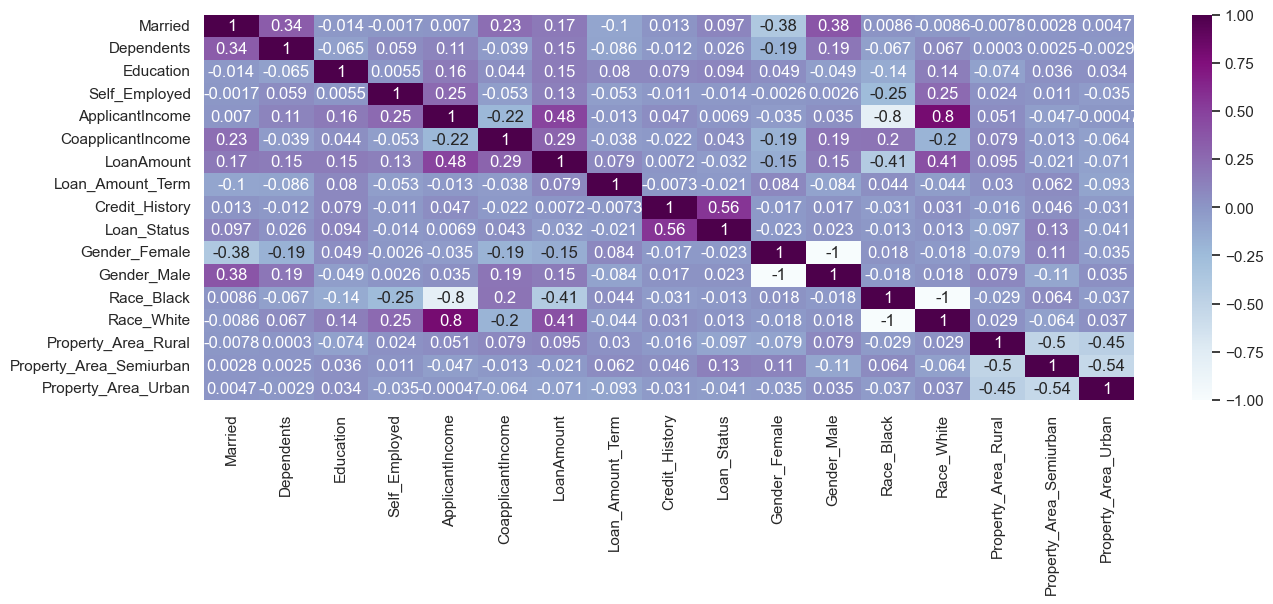

In [34]:
#Checking for correlation again now that we have treated the object columns
plt.figure(figsize=(15,5))
sns.heatmap(train.corr(),cmap='BuPu',annot=True)
plt.show()

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  591 non-null    int64  
 1   Dependents               591 non-null    int32  
 2   Education                591 non-null    int64  
 3   Self_Employed            591 non-null    int64  
 4   ApplicantIncome          591 non-null    int64  
 5   CoapplicantIncome        591 non-null    float64
 6   LoanAmount               591 non-null    float64
 7   Loan_Amount_Term         591 non-null    float64
 8   Credit_History           591 non-null    float64
 9   Loan_Status              591 non-null    int64  
 10  Gender_Female            591 non-null    uint8  
 11  Gender_Male              591 non-null    uint8  
 12  Race_Black               591 non-null    uint8  
 13  Race_White               591 non-null    uint8  
 14  Property_Area_Rural      5

Finally all the object columns are treated and there are no null values in our data so we can start working on model building

# Model building

In [36]:
#Spliting the dataset into features and target
x=train.drop('Loan_Status',axis=1)
y=train['Loan_Status']

In [37]:
#Further splitting the dataset into training and testing data
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.25,stratify=y)

In [38]:
#Using logistic regression supervised ML classification model
lr=LogisticRegression()
lr.fit(xtrain,ytrain)

LogisticRegression()

In [39]:
ypred=lr.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

0.7972972972972973
[[19 27]
 [ 3 99]]
              precision    recall  f1-score   support

           0       0.86      0.41      0.56        46
           1       0.79      0.97      0.87       102

    accuracy                           0.80       148
   macro avg       0.82      0.69      0.71       148
weighted avg       0.81      0.80      0.77       148



# Stratified K-Folds

In [40]:
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
i=1
for train_index,test_index in kf.split(x,y):
    global model
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=x.iloc[train_index],x.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]    
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('Accuracy score: ', score)
    i+=1
    pred_test =model.predict(xtest)
    pred= model.predict_proba(xvl)[:,1]
    
   

1 of kfold 5
Accuracy score:  0.8151260504201681
2 of kfold 5
Accuracy score:  0.7966101694915254
3 of kfold 5
Accuracy score:  0.8135593220338984
4 of kfold 5
Accuracy score:  0.7966101694915254
5 of kfold 5
Accuracy score:  0.8220338983050848


# ROC-AUC Curve 

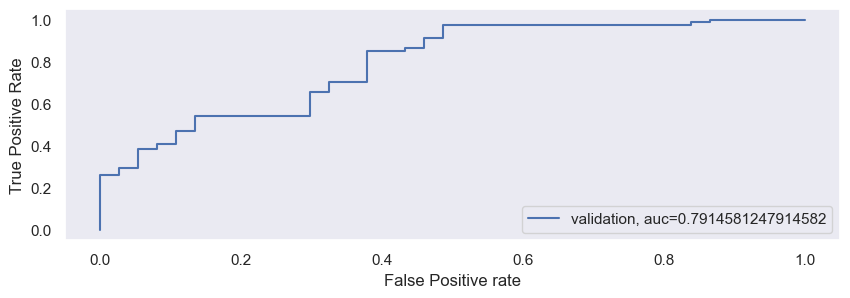

In [41]:
fpr,tpr,_=metrics.roc_curve(yvl,pred)
auc=metrics.roc_auc_score(yvl,pred)
plt.figure(figsize=(10,3))
plt.plot(fpr,tpr,label='validation, auc='+str(auc))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')   
plt.legend(loc=4)
plt.show()

# Submission

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Race               367 non-null    object 
 3   Married            367 non-null    object 
 4   Dependents         357 non-null    object 
 5   Education          367 non-null    object 
 6   Self_Employed      344 non-null    object 
 7   ApplicantIncome    367 non-null    int64  
 8   CoapplicantIncome  367 non-null    int64  
 9   LoanAmount         362 non-null    float64
 10  Loan_Amount_Term   361 non-null    float64
 11  Credit_History     367 non-null    int64  
 12  Property_Area      367 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 37.4+ KB


In [43]:
test['Gender'].fillna(test['Gender'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0],inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].mean(),inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mean(),inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mean(),inplace=True)

In [44]:
test['Dependents']=test['Dependents'].replace('3+',3)
test['Dependents']=test['Dependents'].astype(int)

In [45]:
if 'Loan_ID' in test.columns:
    test.drop('Loan_ID', axis=1, inplace=True)
test['Married']=test['Married'].map({'Yes':1, 'No':0})
test['Self_Employed']=test['Self_Employed'].map({'Yes':1, 'No':0})
test['Education']=test['Education'].map({'Graduate':1, 'Not Graduate':0})

In [46]:
test=pd.get_dummies(test)
test.head()

Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0        1           0          1              0             5720   
1        1           1          1              0             3076   
2        1           2          1              0             5000   
3        0           0          0              0             3276   
4        1           0          0              1             2165   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                  0       110.0             360.0               1   
1               1500       126.0             360.0               1   
2               1800       208.0             360.0               1   
3                  0        78.0             360.0               1   
4               3422       152.0             360.0               1   

   Gender_Female  Gender_Male  Race_Black  Race_White  Property_Area_Rural  \
0              0            1           1           0                    0   
1              0            1           1           0                    0   
2              0            1           1           0                    0   
3              0            1           1           0                    0   
4              0            1           1           0                    0   

   Property_Area_Semiurban  Property_Area_Urban  
0                        0                    1  
1                        0                    1  
2                        0                    1  
3                        0                    1  
4                        0                    1

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  367 non-null    int64  
 1   Dependents               367 non-null    int32  
 2   Education                367 non-null    int64  
 3   Self_Employed            367 non-null    int64  
 4   ApplicantIncome          367 non-null    int64  
 5   CoapplicantIncome        367 non-null    int64  
 6   LoanAmount               367 non-null    float64
 7   Loan_Amount_Term         367 non-null    float64
 8   Credit_History           367 non-null    int64  
 9   Gender_Female            367 non-null    uint8  
 10  Gender_Male              367 non-null    uint8  
 11  Race_Black               367 non-null    uint8  
 12  Race_White               367 non-null    uint8  
 13  Property_Area_Rural      367 non-null    uint8  
 14  Property_Area_Semiurban  3

In [48]:
pred_test=model.predict(test)

In [49]:
submission=pd.DataFrame()
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender']=test_og['Gender']
submission['Race']=test_og['Race']
submission['Loan_Status']=pred_test

In [50]:
submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes', 2: 'No'})

In [51]:
pd.DataFrame(submission, columns=['Loan_ID','Gender','Race', 'Loan_Status']).to_csv('Logistic_Regression.csv')

In [52]:
train.columns

Index(['Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Female',
       'Gender_Male', 'Race_Black', 'Race_White', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')

Data Expansion

In [53]:
# 这里做Mitigation。
# 首先，从train_expaned数据集中随机选择一半的数据
print(train_expaned)
selected_data = train_expaned.sample(frac=0.99, random_state=1)
unselected_data = train_expaned.drop(selected_data.index)

# 对于被选中的每一条数据，复制四次，并将复制的数据中的Race和Gender分别设置为不同的值
expanded_data = []
for _, row in selected_data.iterrows():
    new_row = row.copy()
    # 设置不同的Race和Gender
    new_row['Gender'] = 'Male'
    new_row['Race'] = 'White'
    expanded_data.append(new_row)
    new_row['Race'] = 'Black'
    expanded_data.append(new_row)
    new_row['Gender'] = 'Female'
    new_row['Race'] = 'White'
    expanded_data.append(new_row)
    new_row['Race'] = 'Black'
    expanded_data.append(new_row)

# 将新生成的数据添加到原始数据集中的未被抽取的部分
expanded_data_df = pd.DataFrame(expanded_data)
train_expaned = pd.concat([unselected_data, expanded_data_df], ignore_index=True)

# 打印扩展后的数据集
print(train_expaned)
# train_expaned.to_csv('train_expaned.csv', index=False)


     Gender   Race  Married  Dependents  Education  Self_Employed  \
0      Male  Black        0           0          1              0   
1      Male  Black        1           1          1              0   
2      Male  Black        1           0          1              1   
3      Male  Black        1           0          0              0   
4      Male  Black        0           0          1              0   
..      ...    ...      ...         ...        ...            ...   
609  Female  Black        0           0          1              0   
610    Male  Black        1           3          1              0   
611    Male  White        1           1          1              0   
612    Male  White        1           2          1              0   
613  Female  Black        0           0          1              1   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849                0.0      146.41             360.0   
1               4583     

In [54]:
# 开始训练LR,Mitigation后，并使用test测试，输出
train_expaned=pd.get_dummies(train_expaned)
x=train_expaned.drop('Loan_Status',axis=1)
y=train_expaned['Loan_Status']

xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.25,stratify=y)

lr=LogisticRegression()
lr.fit(xtrain,ytrain)

ypred=lr.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

kf=StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
i=1
for train_index,test_index in kf.split(x,y):
    global model
#     print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=x.iloc[train_index],x.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]    
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
#     print('Accuracy score: ', score)
    i+=1
    pred_test =model.predict(xtest)
    pred= model.predict_proba(xvl)[:,1]
    
    
pred_test=model.predict(test)

submission=pd.DataFrame()
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender']=test_og['Gender']
submission['Race']=test_og['Race']
submission['Loan_Status']=pred_test

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes', 2: 'No'})

pd.DataFrame(submission, columns=['Loan_ID','Gender','Race', 'Loan_Status']).to_csv('Logistic_Regression_after_Mitigation.csv')

0.8194207836456558
[[ 83  98]
 [  8 398]]
              precision    recall  f1-score   support

           0       0.91      0.46      0.61       181
           1       0.80      0.98      0.88       406

    accuracy                           0.82       587
   macro avg       0.86      0.72      0.75       587
weighted avg       0.84      0.82      0.80       587



# Feature Engineering

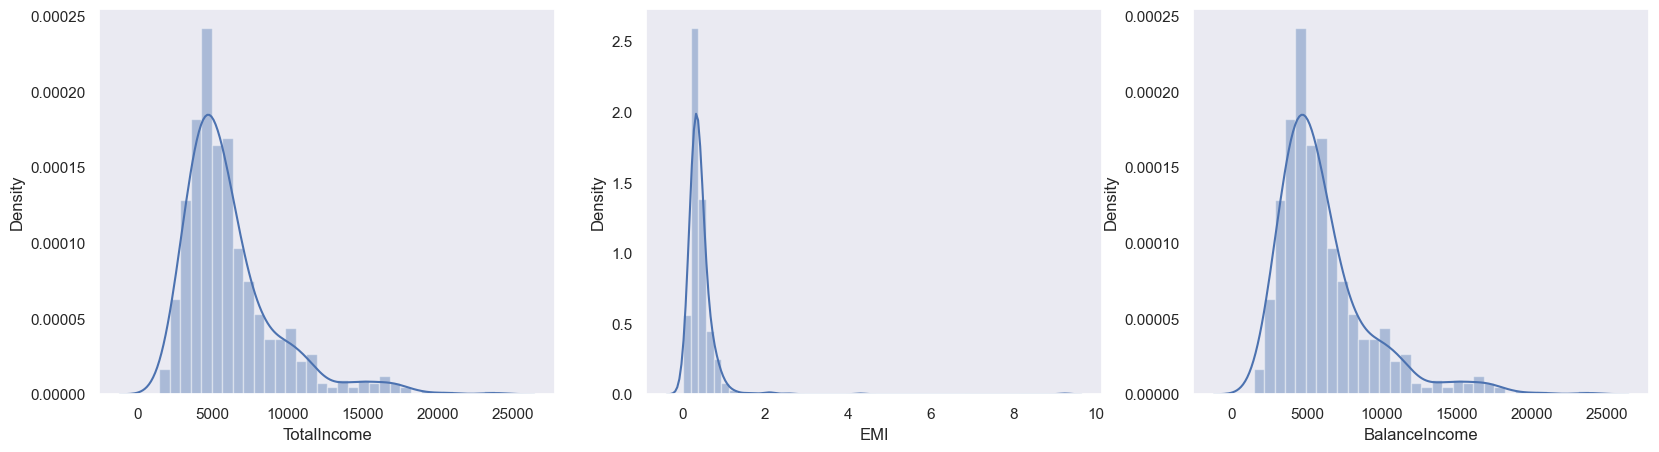

In [55]:
train['TotalIncome']=train['ApplicantIncome']+train['CoapplicantIncome']
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term']
train['BalanceIncome']=train['TotalIncome']-train['EMI']

train_expaned['TotalIncome']=train_expaned['ApplicantIncome']+train_expaned['CoapplicantIncome']
train_expaned['EMI']=train_expaned['LoanAmount']/train_expaned['Loan_Amount_Term']
train_expaned['BalanceIncome']=train_expaned['TotalIncome']-train_expaned['EMI']

plt.figure(1,figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(train['TotalIncome'])
plt.subplot(1,3,2)
sns.distplot(train['EMI'])
plt.subplot(1,3,3)
sns.distplot(train['BalanceIncome'])
plt.show()

In [56]:
test['TotalIncome']=test['ApplicantIncome']+test['CoapplicantIncome']
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']
test['BalanceIncome']=test['TotalIncome']-test['EMI']

In [57]:
train.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)
train_expaned.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)
test.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)


# Testing multiple models

In [58]:
# x=train.drop('Loan_Status', axis=1)
# y=train['Loan_Status']
x=train_expaned.drop('Loan_Status',axis=1)
y=train_expaned['Loan_Status']

In [59]:
def model(model_name,feature,target):
    i=1
    kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    for train_index,test_index in kf.split(x,y):
        print('{} of kfold {}'.format(i,kf.n_splits))
        xtr,xte= x.iloc[train_index],x.iloc[test_index]
        ytr,yte=y.iloc[train_index],y.iloc[test_index]
        
        model=model_name
        model.fit(xtr,ytr)
        pred=model.predict(xte)
        score=accuracy_score(yte,pred)
        print('Accuracy_score: ',score)
        i+=1
        pred_test=model.predict(test)
        pred=model.predict_proba(xte)[:,1]
    

In [60]:
model(LogisticRegression(),x,y)

1 of kfold 5
Accuracy_score:  0.8106382978723404
2 of kfold 5
Accuracy_score:  0.8230277185501066
3 of kfold 5
Accuracy_score:  0.8123667377398721
4 of kfold 5
Accuracy_score:  0.8081023454157783
5 of kfold 5
Accuracy_score:  0.8166311300639659


In [61]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender']=test_og['Gender']
submission['Race']=test_og['Race']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Gender','Race','Loan_Status']).to_csv('LogisticRegression2.csv')

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
dt=DecisionTreeClassifier()

In [63]:
model(dt,x,y)

1 of kfold 5
Accuracy_score:  0.997872340425532
2 of kfold 5
Accuracy_score:  0.9914712153518124
3 of kfold 5
Accuracy_score:  0.9914712153518124
4 of kfold 5
Accuracy_score:  0.9914712153518124
5 of kfold 5
Accuracy_score:  0.9914712153518124


In [64]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender']=test_og['Gender']
submission['Race']=test_og['Race']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Gender','Race','Loan_Status']).to_csv('DecisionTreeClassifier.csv')

In [65]:
model(RandomForestClassifier(max_depth=10, random_state=2),x,y)

1 of kfold 5
Accuracy_score:  0.9127659574468086
2 of kfold 5
Accuracy_score:  0.9125799573560768
3 of kfold 5
Accuracy_score:  0.9317697228144989
4 of kfold 5
Accuracy_score:  0.9275053304904051
5 of kfold 5
Accuracy_score:  0.9104477611940298


# GridSearchCV

In [66]:
parameters={'max_depth':list(range(1,20,2)),'n_estimators': list(range(1,200,20))}
grid=GridSearchCV(RandomForestClassifier(random_state=1), parameters)

xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=1,test_size=0.25)
grid.fit(xtrain,ytrain)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161,
                                          181]})

In [67]:
grid.best_params_
grid.best_score_
print(grid.best_estimator_)
model=grid.best_estimator_
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)

RandomForestClassifier(max_depth=17, n_estimators=61, random_state=1)


In [68]:
rfc=RandomForestClassifier(max_depth=5,n_estimators=21 ,random_state=1)
rfc.fit(xtrain,ytrain)
ypred=rfc.predict(xtest)

In [69]:
pred_test=rfc.predict(test)

In [70]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender']=test_og['Gender']
submission['Race']=test_og['Race']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Gender','Race','Loan_Status']).to_csv('RandomForestClassifier.csv')

# Feature Importance

<AxesSubplot: >

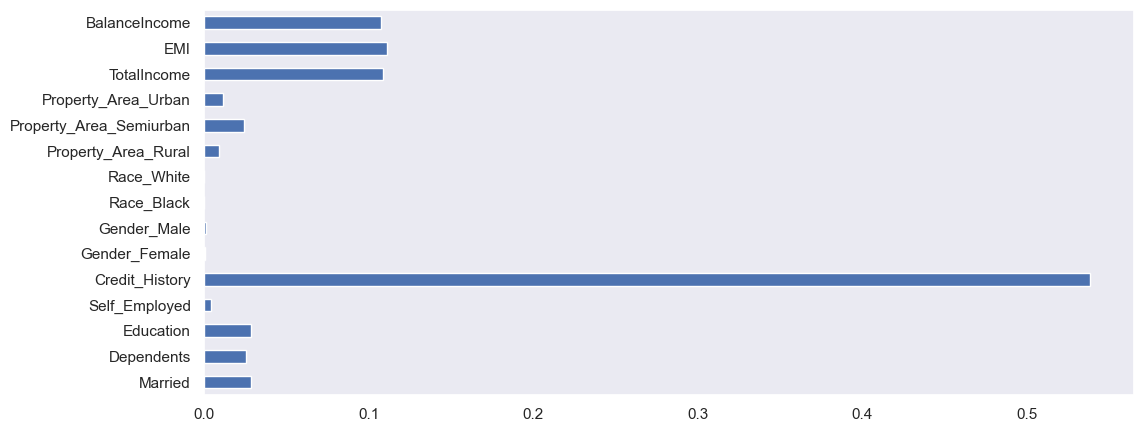

In [71]:
importances=pd.Series(rfc.feature_importances_, index=x.columns)
importances.plot(kind='barh',figsize=(12,5))

# XGB CLassifier

In [72]:
i=1
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
for train_index,test_index in kf.split(x,y):
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xte= x.iloc[train_index],x.iloc[test_index]
    ytr,yte=y.iloc[train_index],y.iloc[test_index]
        
    model=XGBClassifier()
    model.fit(xtr,ytr)
    pred=model.predict(xte)
    score=accuracy_score(yte,pred)
    print('Accuracy_score: ',score)
    i+=1
    pred_test=model.predict(test)
    pred=model.predict_proba(xte)[:,1]

1 of kfold 5
Accuracy_score:  1.0
2 of kfold 5
Accuracy_score:  0.9936034115138592
3 of kfold 5
Accuracy_score:  0.9893390191897654
4 of kfold 5
Accuracy_score:  0.9914712153518124
5 of kfold 5
Accuracy_score:  0.9914712153518124


In [73]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']
submission['Gender']=test_og['Gender']
submission['Race']=test_og['Race']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Gender','Race','Loan_Status']).to_csv('XGBClassifier.csv')

# Thankyou :)